<a href="https://colab.research.google.com/github/fancyparis9456/Deep-Learning/blob/main/House_Rent(Regression)_ANN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Basic packages always been used
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data scaling
from sklearn.preprocessing import MinMaxScaler

# Function for spilting training & testing data set
from sklearn.model_selection import train_test_split

# Tensorflow sequential models
from tensorflow import keras
from keras import backend as clear
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.optimizers import SGD
from keras.optimizers import Adam

# Functions for evaluation
from sklearn.metrics import mean_absolute_error #MAE
from sklearn.metrics import mean_squared_error #MSE,RMSE
from sklearn.metrics import mean_absolute_percentage_error #MAPE

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Note: Some metrics need to be defined manually

In [ ]:
# Symmetric Mean Absolute Percentage Error (SMAPE)
def SMAPE_calulate(y_true, y_pred):
    n = len(y_true)
    SMAPE=(100 / n) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))
    return SMAPE

# Relative Absolute Error (RAE)
def RAE_calculate(y_true, y_pred):
    abs_errors = np.abs(y_true - y_pred)
    denominator = np.sum(np.abs(y_true - np.mean(y_true)))
    RAE=np.sum(abs_errors/denominator)
    return RAE

# Mean Relative Absolute Error (MRAE)
def MRAE_calculate(y_true, y_pred):
    n=len(y_true)
    abs_errors = np.abs(y_true - y_pred)
    denominator = np.sum(np.abs(y_true - np.mean(y_true)))
    RAE=np.sum(abs_errors/denominator)
    MRAE=RAE/n
    return MRAE

# Median Relative Absolute Error (MdRAE) comparing with benchmark
# Note: By default, the bench value is the mean of actual value
def MdRAE_calculate(y_true, y_pred, bench=None):
    if bench==None:
        bench=np.mean(y_true)
        MdRAE=np.median(np.abs(y_true - y_pred)/np.abs(y_true - bench))
        return MdRAE,bench
    else:
        MdRAE=np.median(np.abs(y_true - y_pred)/np.abs(y_true - bench))
        return MdRAE
    
# Relative Squared Error (RSE) & Root Relative Squared Error (RRSE)
def RSE_calculate(y_true, y_pred, Root=False):
    mse = np.mean((y_true - y_pred)**2)
    denominator = np.var(y_true)
    RSE=mse/denominator
    
    if Root==True:
        return np.sqrt(RSE)
    else:
        return RSE

In [ ]:
#load data(sometimes need to use "/")
#df = pd.read_csv('D:/pythonData/python_demo_data/House_Rent_Dataset.csv')
# Colab
df = pd.read_csv('/content/drive/MyDrive/DL/House_Rent_Dataset.csv')
df

,Rent,Size,BHK,Bathroom,Furnishing Status,City
0,10000,1100,2,2,Unfurnished,Kolkata
1,20000,800,2,1,Semi-Furnished,Kolkata
2,17000,1000,2,1,Semi-Furnished,Kolkata
3,10000,800,2,1,Unfurnished,Kolkata
4,7500,850,2,1,Unfurnished,Kolkata
...,...,...,...,...,...,...
4741,15000,1000,2,2,Semi-Furnished,Hyderabad
4742,29000,2000,3,3,Semi-Furnished,Hyderabad
4743,35000,1750,3,3,Semi-Furnished,Hyderabad
4744,45000,1500,3,2,Semi-Furnished,Hyderabad


# 1. Quick overview to get a grasp of the data set

key function: pd.info(); pd.astype(); describe(); pd.value_counts()

In [ ]:
# 1.1 Easiest way to check data type and if there are any missing value
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4746 entries, 0 to 4745
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Rent               4746 non-null   int64 
 1   Size               4746 non-null   int64 
 2   BHK                4746 non-null   int64 
 3   Bathroom           4746 non-null   int64 
 4   Furnishing Status  4746 non-null   object
 5   City               4746 non-null   object
dtypes: int64(4), object(2)
memory usage: 222.6+ KB


In [ ]:
# 1.2 When using the describe function in default, pandas automatically selects the numerical columns
df.describe()

,Rent,Size,BHK,Bathroom
count,4.746000e+03,4746.000000,4746.000000,4746.000000
mean,3.499345e+04,967.490729,2.083860,1.965866
std,7.810641e+04,634.202328,0.832256,0.884532
min,1.200000e+03,10.000000,1.000000,1.000000
25%,1.000000e+04,550.000000,2.000000,1.000000
50%,1.600000e+04,850.000000,2.000000,2.000000
75%,3.300000e+04,1200.000000,3.000000,2.000000
max,3.500000e+06,8000.000000,6.000000,10.000000


Note: Pclass is categorical data with dummies, so converting to correct data type is required

In [ ]:
# 1.3 Using value_counts function to count frequency in categorical column
print(df[['Furnishing Status']].value_counts(sort=True))
print('+-----------------------+')
print(df[['City']].value_counts(sort=True))
print('+-----------------------+')

Furnishing Status
Semi-Furnished       2251
Unfurnished          1815
Furnished             680
dtype: int64
+-----------------------+
City     
Mumbai       972
Chennai      891
Bangalore    886
Hyderabad    868
Delhi        605
Kolkata      524
dtype: int64
+-----------------------+


# 2. Data preprocessing

key function: pd.dropma() unique(); LabelEncoder(); pd.get_dummies

In [ ]:
#2.1 Using pd.get_dummies function to generate dummies
dummied_df=pd.get_dummies(df,columns=['Furnishing Status','City'])
dummied_df

,Rent,Size,BHK,Bathroom,Furnishing Status_Furnished,Furnishing Status_Semi-Furnished,Furnishing Status_Unfurnished,City_Bangalore,City_Chennai,City_Delhi,City_Hyderabad,City_Kolkata,City_Mumbai
0,10000,1100,2,2,0,0,1,0,0,0,0,1,0
1,20000,800,2,1,0,1,0,0,0,0,0,1,0
2,17000,1000,2,1,0,1,0,0,0,0,0,1,0
3,10000,800,2,1,0,0,1,0,0,0,0,1,0
4,7500,850,2,1,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4741,15000,1000,2,2,0,1,0,0,0,0,1,0,0
4742,29000,2000,3,3,0,1,0,0,0,0,1,0,0
4743,35000,1750,3,3,0,1,0,0,0,0,1,0,0
4744,45000,1500,3,2,0,1,0,0,0,0,1,0,0


Note: get_dummies function generates the onehotencode style dummies

In [ ]:
# Export to CSV file Note: preset folder path is required
#dummied_df.to_csv('D:/data_analysis/PyExport/House_Rent_dummied.csv',index=False, header=True)
# Colab
dummied_df.to_csv('House_Rent_dummied.csv',index=False, header=True)
print('Export complete...')

Export complete...


# 3. Set dependent variable(Y or target) & independent variable(X) 

In [ ]:
#set x (make prediction) with minimax
x=dummied_df.drop(['Rent'],axis=1).copy()

#set y (want to predict)
y=dummied_df['Rent'].copy()

Note: Target variable Y does not need to be scaled, so we  need to separate dependent variabe and independent variables first

# 4. Data scaling with minimax technique

Key function: MinMaxScaler()

In [ ]:
#minimax scaling
MMscaler=MinMaxScaler(feature_range=(0, 1))
scaling=MMscaler.fit_transform(x)
scaled_x=pd.DataFrame(data=scaling)
scaled_x.columns=x.columns
scaled_x.head()

,Size,BHK,Bathroom,Furnishing Status_Furnished,Furnishing Status_Semi-Furnished,Furnishing Status_Unfurnished,City_Bangalore,City_Chennai,City_Delhi,City_Hyderabad,City_Kolkata,City_Mumbai
0,0.136421,0.2,0.111111,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.098874,0.2,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.123905,0.2,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.098874,0.2,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.105131,0.2,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


# 5. Spilt the data into train & test set

key function: train_test_split()

key parameters for train_test_spilt(): test_size; random_state 

In [ ]:
#prepare dataset with scaling
#Split the data (split into 80% training data & 20% testing data) (lock seed)
x_train,x_test,y_train,y_test=train_test_split(scaled_x,y,test_size=0.2,random_state=2)

In [ ]:
# 
print('Amount of training samples:',len(y_train))
print('+----------------------------------------+')
print('Amount of testing samples:',len(y_test))

Amount of training samples: 3796
+----------------------------------------+
Amount of testing samples: 950


# 6. Creating Net 

In [ ]:
# Quick recap: Total of 12 features in the data set
scaled_x.head()

,Size,BHK,Bathroom,Furnishing Status_Furnished,Furnishing Status_Semi-Furnished,Furnishing Status_Unfurnished,City_Bangalore,City_Chennai,City_Delhi,City_Hyderabad,City_Kolkata,City_Mumbai
0,0.136421,0.2,0.111111,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.098874,0.2,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.123905,0.2,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.098874,0.2,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.105131,0.2,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
# Tips: Using shape to call the amount of features in the data set 
input_features=scaled_x.shape[1]
print('Amount of features:',input_features)

Amount of features: 12


# Important: Define customized loss function (RMSE)

In [ ]:
from keras.losses import mse
from keras.backend import sqrt

def my_RMSE(y_true, y_pred):
    return sqrt(mse(y_true, y_pred))

# Register custom object
#from keras.utils.generic_utils import get_custom_objects for pc
from tensorflow.keras.saving import get_custom_objects
get_custom_objects().update({'my_RMSE': my_RMSE})

Note: As far as I know when I'm preparing this in-class material, keras does not have a built-in RMSE function. Rumor has it that a RMSE function is hidden in the latest version, however it needs to be confirmed. For instance, defining RMSE ourself is not difficult, just don't forget to register our custom functions.   

# Sequential style coding for creating net

In [140]:
# 6.1 Create the model
clear.clear_session()
model=Sequential()

# 6.2 Add input layer & first hidden layer
model.add(Dense(units=24, input_dim=12, activation='relu'))

# 6.3 Add second hidden layer
model.add(Dense(units=48, activation='linear'))

# 6.4 Add third hidden layer
model.add(Dense(units=96, activation='relu'))

model.add(Dense(units=192, activation='linear'))

# 6.5 Add output layer
model.add(Dense(units=1, activation='linear'))

# 6.6 Compile the defined Net
#opt=SGD(learning_rate=0.001,momentum=0.5)
opt=Adam(learning_rate=0.005,beta_1=0.8)
model.compile(loss='my_RMSE', optimizer=opt, metrics=['mean_absolute_percentage_error'])

# Finally check the model 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 24)                312       
                                                                 
 dense_1 (Dense)             (None, 48)                1200      
                                                                 
 dense_2 (Dense)             (None, 96)                4704      
                                                                 
 dense_3 (Dense)             (None, 192)               18624     
                                                                 
 dense_4 (Dense)             (None, 1)                 193       
                                                                 
Total params: 25,033
Trainable params: 25,033
Non-trainable params: 0
_________________________________________________________________


Note: Remember to clear the session or else some of the left neurans may cause trouble while fitting

# 7. Fit the model

# Note: The validation set should be split manually

In [141]:
# Important
x_training,x_validation,y_training,y_validation=train_test_split(x_train,y_train,test_size=0.2,random_state=2)

# 7.1 Store in the history for more useful information
history=model.fit(x_training, y_training, epochs=100, batch_size=64,verbose=1,validation_data=(x_validation, y_validation))

Epoch 1/100
48/48 [==============================] - 1s 9ms/step - loss: 28405.6523 - mean_absolute_percentage_error: 76.9585 - val_loss: 21434.7070 - val_mean_absolute_percentage_error: 62.2246
Epoch 2/100
48/48 [==============================] - 0s 4ms/step - loss: 18619.4395 - mean_absolute_percentage_error: 47.9527 - val_loss: 16376.8760 - val_mean_absolute_percentage_error: 45.7655
Epoch 3/100
48/48 [==============================] - 0s 4ms/step - loss: 16261.1064 - mean_absolute_percentage_error: 42.7744 - val_loss: 15407.8594 - val_mean_absolute_percentage_error: 42.0842
Epoch 4/100
48/48 [==============================] - 0s 5ms/step - loss: 14797.1465 - mean_absolute_percentage_error: 38.6608 - val_loss: 14557.5732 - val_mean_absolute_percentage_error: 40.5101
Epoch 5/100
48/48 [==============================] - 0s 4ms/step - loss: 13699.4199 - mean_absolute_percentage_error: 36.8346 - val_loss: 13791.2920 - val_mean_absolute_percentage_error: 41.0500
Epoch 6/100
48/48 [======

In [142]:
# Check the dictionary keys
modeling_result=history.history
modeling_result.keys()

dict_keys(['loss', 'mean_absolute_percentage_error', 'val_loss', 'val_mean_absolute_percentage_error'])

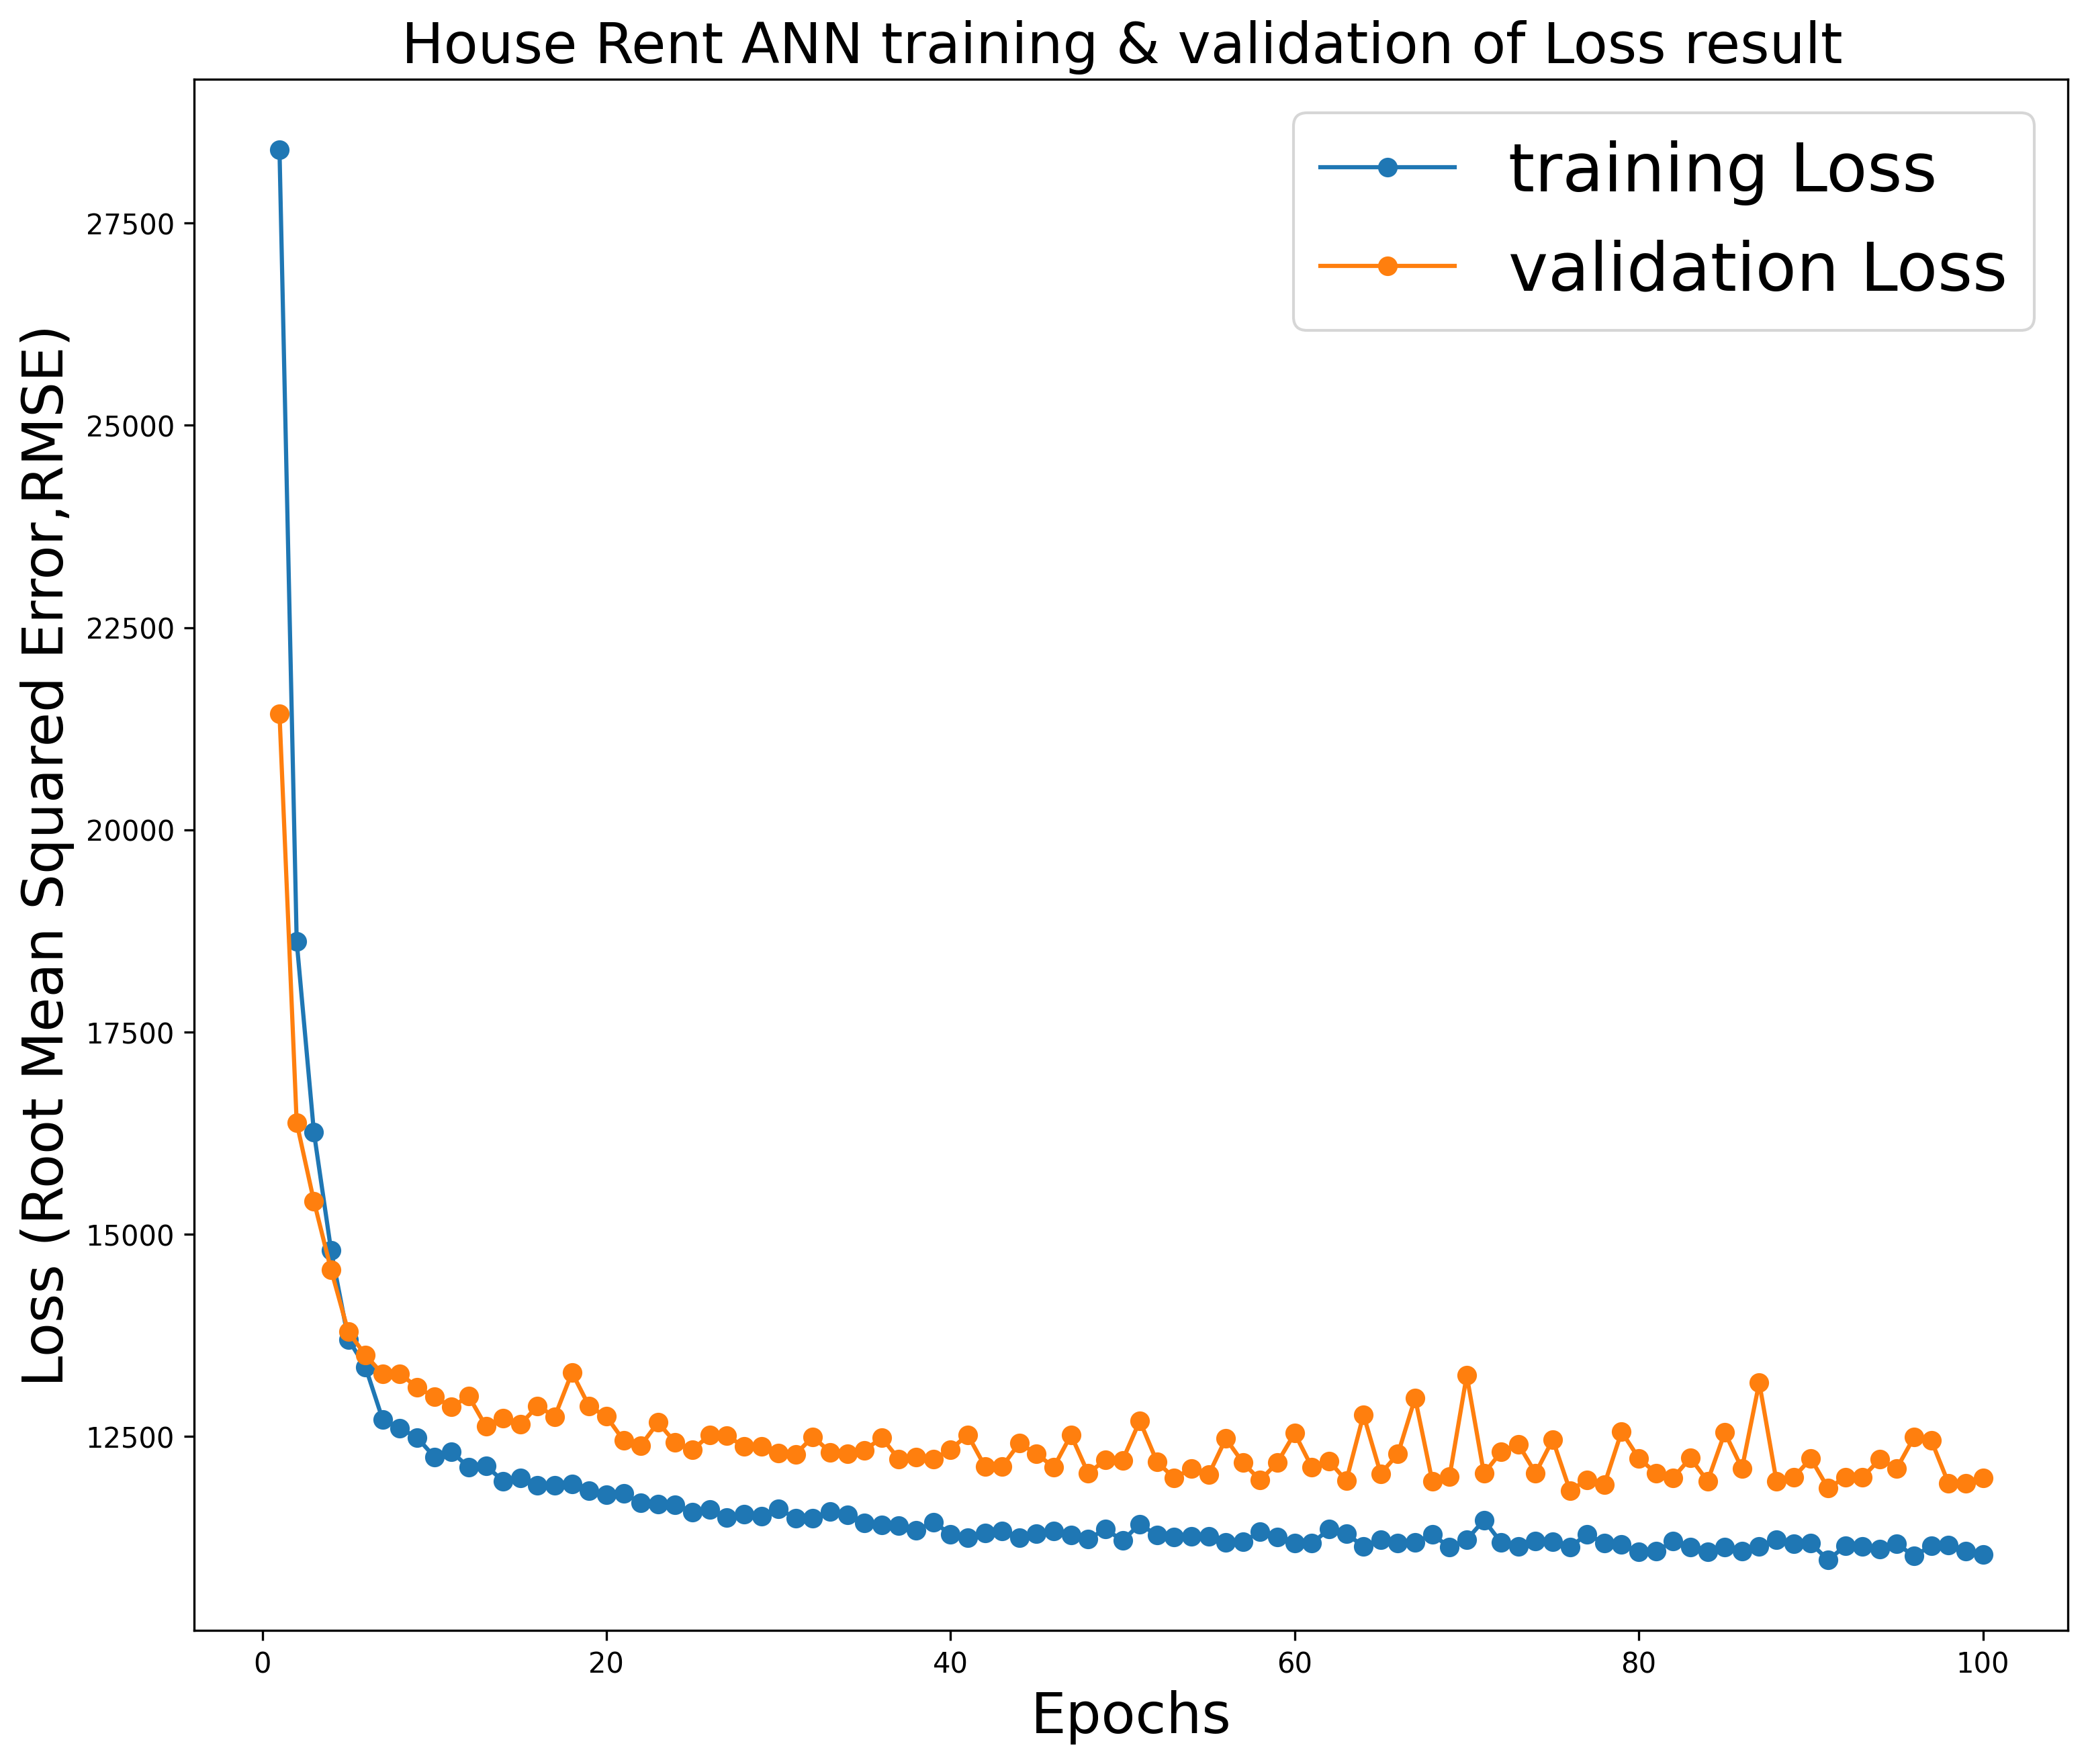

In [143]:
# 7.2 Plot the history of training and validation
training_loss_values=modeling_result['loss']
val_loss_values=modeling_result['val_loss']
epochs=range(1,len(training_loss_values)+1)

plt.figure(figsize=(12,10),dpi=300)
plt.xlabel('Epochs',fontsize=20)
plt.ylabel('Loss (Root Mean Squared Error,RMSE)',fontsize=20)
plt.title('House Rent ANN training & validation of Loss result ',fontsize=20)

plt.plot(epochs, training_loss_values,marker='o',label='training Loss')
plt.plot(epochs, val_loss_values,marker='o',label='validation Loss')
plt.legend(loc=1,fontsize=24)
plt.show()

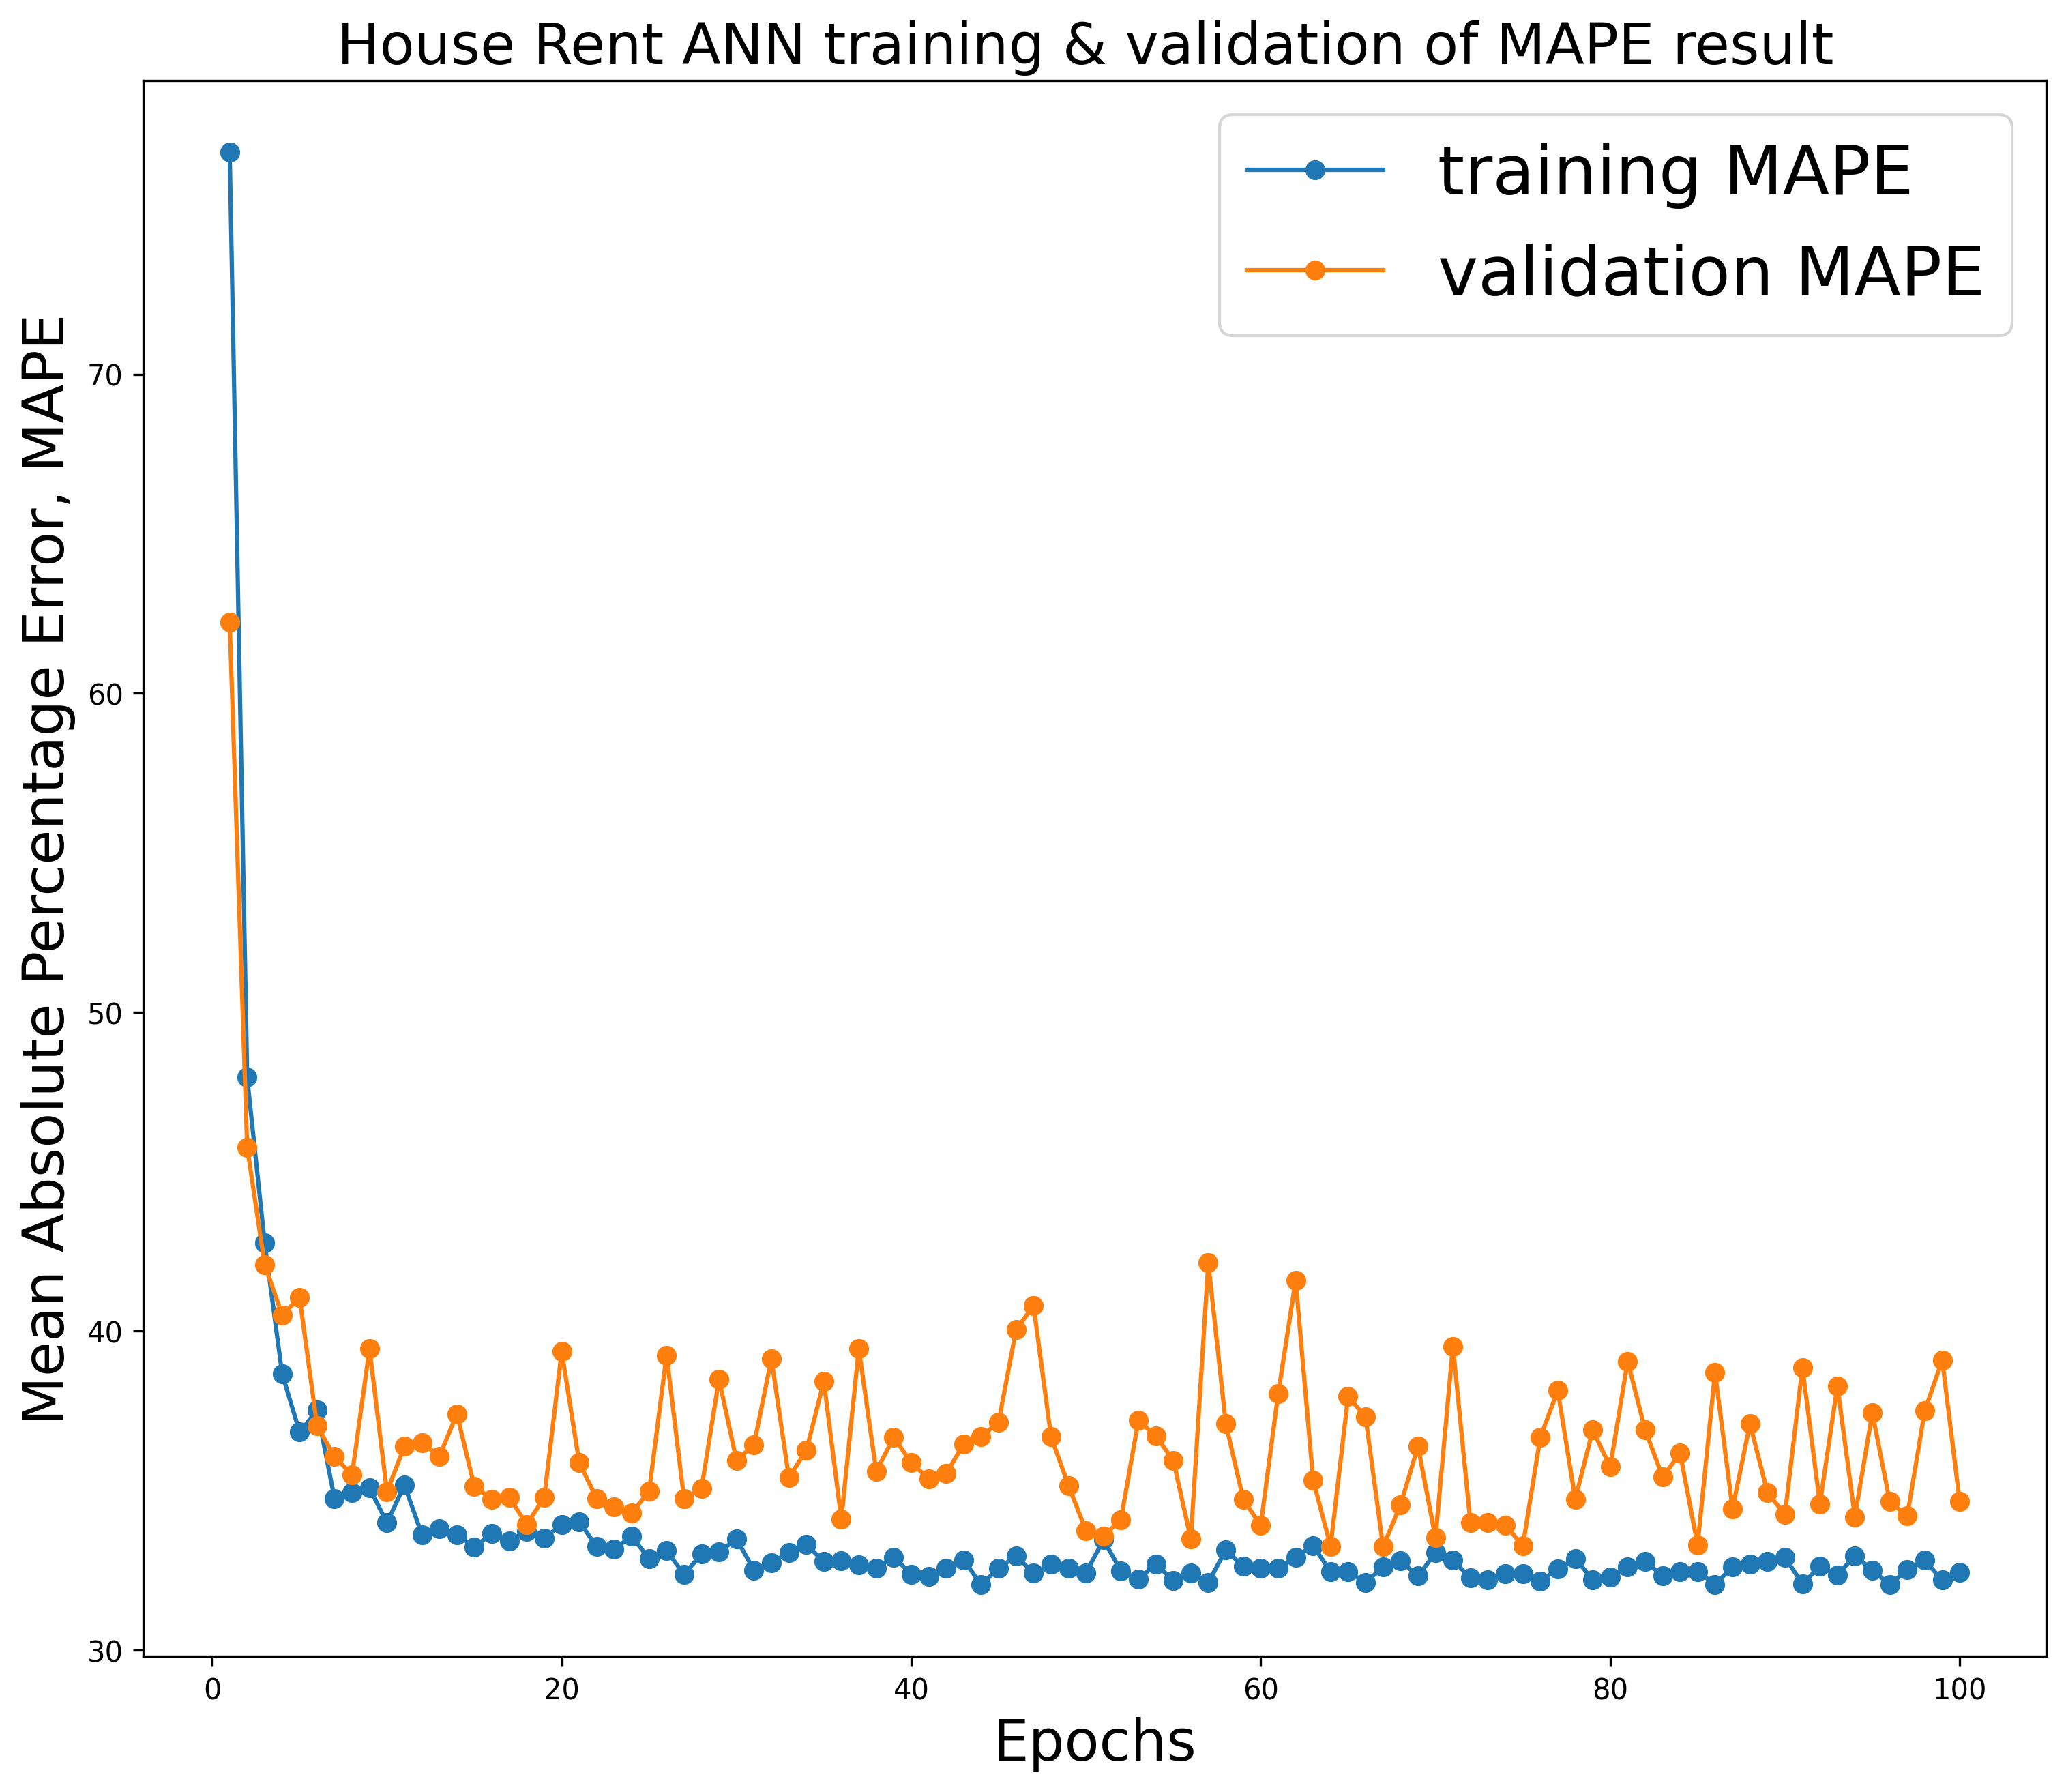

In [144]:
# 7.2 Plot the history of training and validation
training_acc_values=modeling_result['mean_absolute_percentage_error']
val_acc_values=modeling_result['val_mean_absolute_percentage_error']
epochs=range(1,len(training_acc_values)+1)

plt.figure(figsize=(12,10),dpi=300)
plt.xlabel('Epochs',fontsize=20)
plt.ylabel('Mean Absolute Percentage Error, MAPE',fontsize=20)
plt.title('House Rent ANN training & validation of MAPE result ',fontsize=20)

plt.plot(epochs, training_acc_values,marker='o',label='training MAPE')
plt.plot(epochs, val_acc_values,marker='o',label='validation MAPE')
plt.legend(loc=1,fontsize=24)
plt.show()

In [145]:
# 7.3 Save the trained model
#model.save('D:/data_analysis/PyExport/House_Rent_ANN_trained_model.h5')
# Colab
model.save('Rent_4_0.005_0.8.h5')
print('Model has been saved...')

Model has been saved...


In [147]:
# 7.4 Restore the saved model for testing
#ANN_model=keras.models.load_model('D:/data_analysis/PyExport/House_Rent_ANN_trained_model.h5')
# Colab
ANN_model=keras.models.load_model('Rent_4_0.005_0.8.h5')
print('Model successfully loaded...')

Model successfully loaded...


# 8. Testing

In [148]:
# 8.1 Make prediction 
prediction=np.round(ANN_model.predict_on_batch(x_test),0)
prediction=prediction.astype('int')
pred_values=[]
for i in range(0,len(prediction)):
    value=prediction[i][0]
    pred_values.append(value)

Note: Since Rent value is integer, we need to transform the outputs and convert the data type.

In [149]:
Results=pd.DataFrame({'Num':range(1,len(prediction)+1),'Y_true':y_test,'Predict':pred_values})
Results['abs Error']=np.abs(Results['Y_true']-Results['Predict'])
Results

,Num,Y_true,Predict,abs Error
4014,1,9500,14072,4572
4709,2,6000,6185,185
1649,3,17500,18558,1058
2648,4,10000,13020,3020
2717,5,16500,15791,709
...,...,...,...,...
3908,946,35000,23746,11254
3550,947,10000,7126,2874
2540,948,16000,10077,5923
4231,949,10000,11484,1484


In [150]:
# 8.2 Calculating the mertics
MAE=mean_absolute_error(y_test,pred_values)
MSE=mean_squared_error(y_test,pred_values,squared=True)
RMSE=mean_squared_error(y_test,pred_values,squared=False)
MAPE=mean_absolute_percentage_error(y_test,pred_values)
SMAPE=SMAPE_calulate(y_test,pred_values)
RAE=RAE_calculate(y_test,pred_values)
MRAE=MRAE_calculate(y_test,pred_values)
MdRAE=MdRAE_calculate(y_test,pred_values)
RSE=RSE_calculate(y_test,pred_values,Root=False)
RRSE=RSE_calculate(y_test,pred_values,Root=True)

print('MAE:',round(MAE,3))
print('MSE:',round(MSE,3))
print('RMSE:',round(RMSE,3))
print('MAPE:',round(MAPE*100,3),'%')
print('SMAPE:',round(SMAPE,3),'%')
print('RAE:',round(RAE,3))
print('MRAE:',MRAE)
print('MdRAE:',round(MdRAE[0],3),'bench:',round(MdRAE[1],3))
print('RSE:',round(RSE,3))
print('RRSE:',round(RRSE,3))

MAE: 15020.297
MSE: 13079094996.366
RMSE: 114363.871
MAPE: 32.929 %
SMAPE: 31.826 %
RAE: 0.446
MRAE: 0.00046921052244244896
MdRAE: 0.183 bench: 36943.071
RSE: 0.877
RRSE: 0.936


# Scatter plot for comparing true value & predicted value 

In [151]:
# Figure setting
plt.figure(figsize=(30,8),dpi=600)
plt.title('True value vs Predict value',weight='bold',fontsize=36)
plt.xlabel('Observations',fontsize=24,weight='bold')
plt.ylabel('Value',fontsize=24,weight='bold')

# Scatter plot
plt.scatter(Results.iloc[:,0],Results.iloc[:,1],color='blue',label='Y_true')
plt.scatter(Results.iloc[:,0],Results.iloc[:,2],color='red',label='Y_pred')

# Figure setting
plt.legend(loc=1,fontsize=24)
# Set x-axis to let the plot looks nice
plt.xlim(-50,1000)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

# Actual by predicted plot

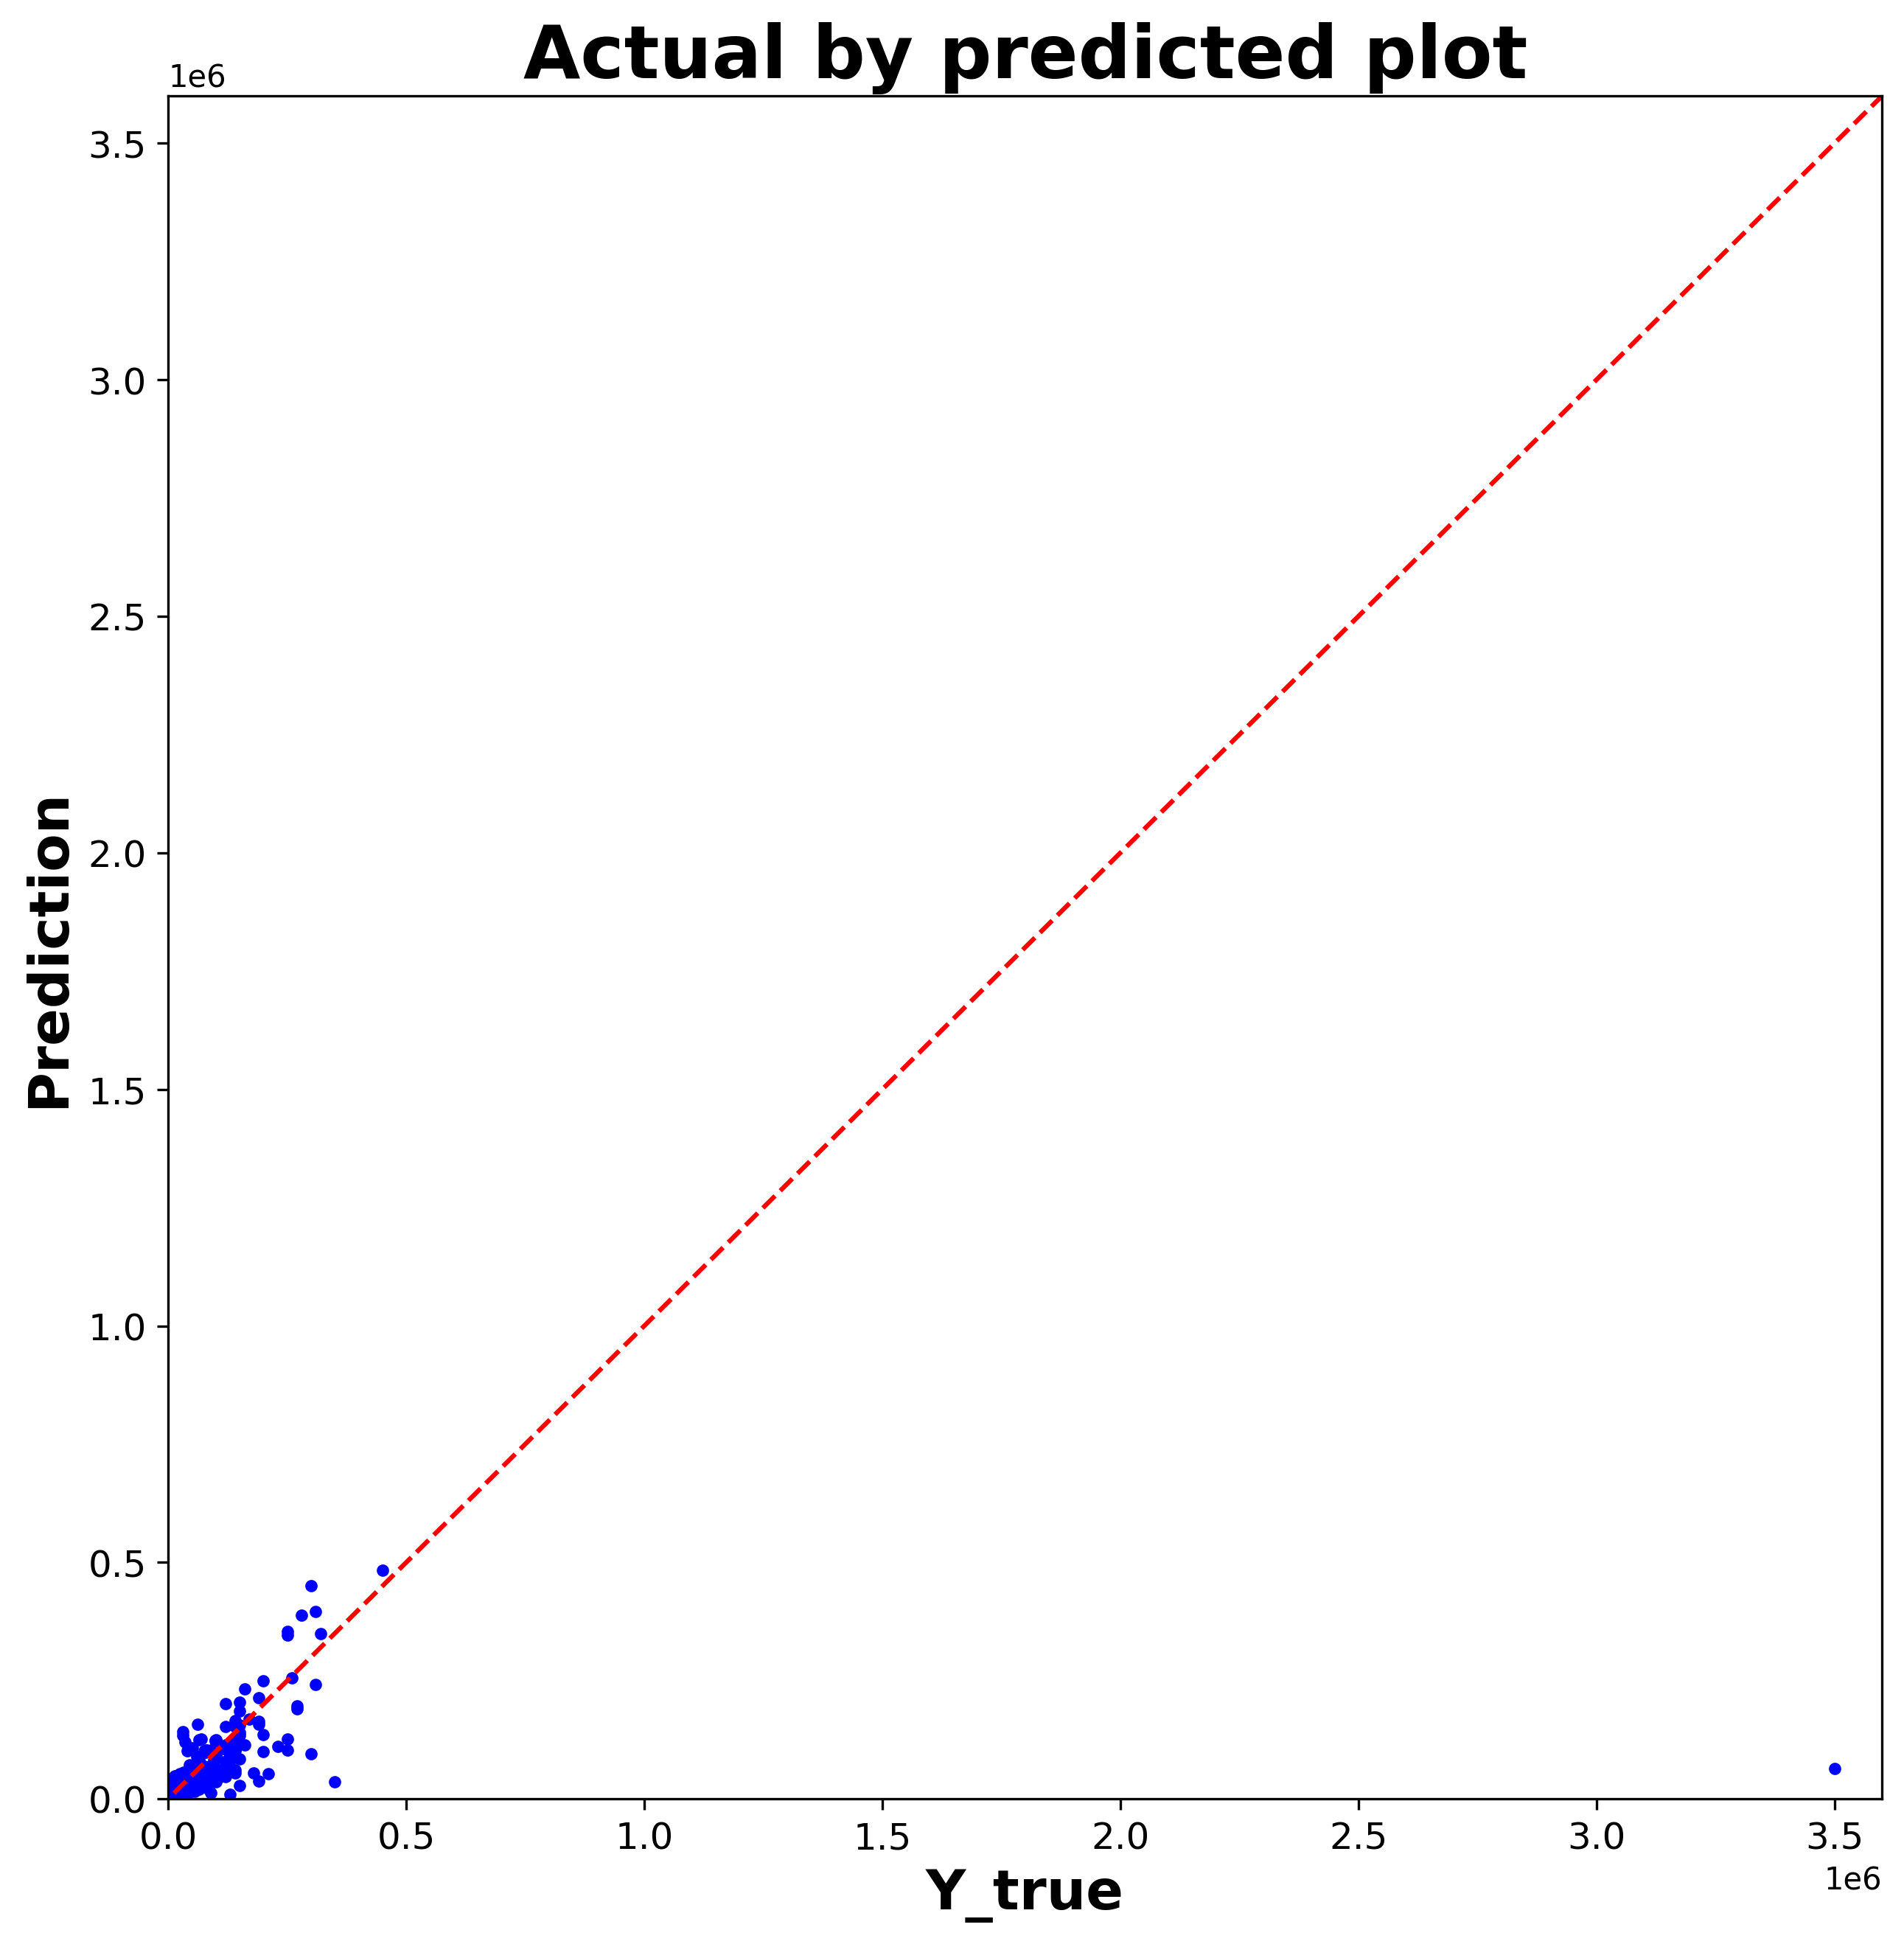

In [152]:
# Lock the scale of axis by Y_true
max_value=max(y_test)+100000
min_value=min(y_test)-100000

# Figure setting
plt.figure(figsize=(10,10),dpi=300)
plt.title('Actual by predicted plot',weight='bold',fontsize=24)
plt.xlabel('Y_true',fontsize=18,weight='bold')
plt.ylabel('Prediction',fontsize=18,weight='bold')

# Perfect model reference line
plt.plot([min_value,max_value], [min_value,max_value], linestyle='--',color='red')

# Actual by predicted plot
plt.scatter(Results.iloc[:,1],Results.iloc[:,2],marker='.',color='blue')

# Set the axis
plt.ylim(0,max_value)
plt.xlim(0,max_value)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

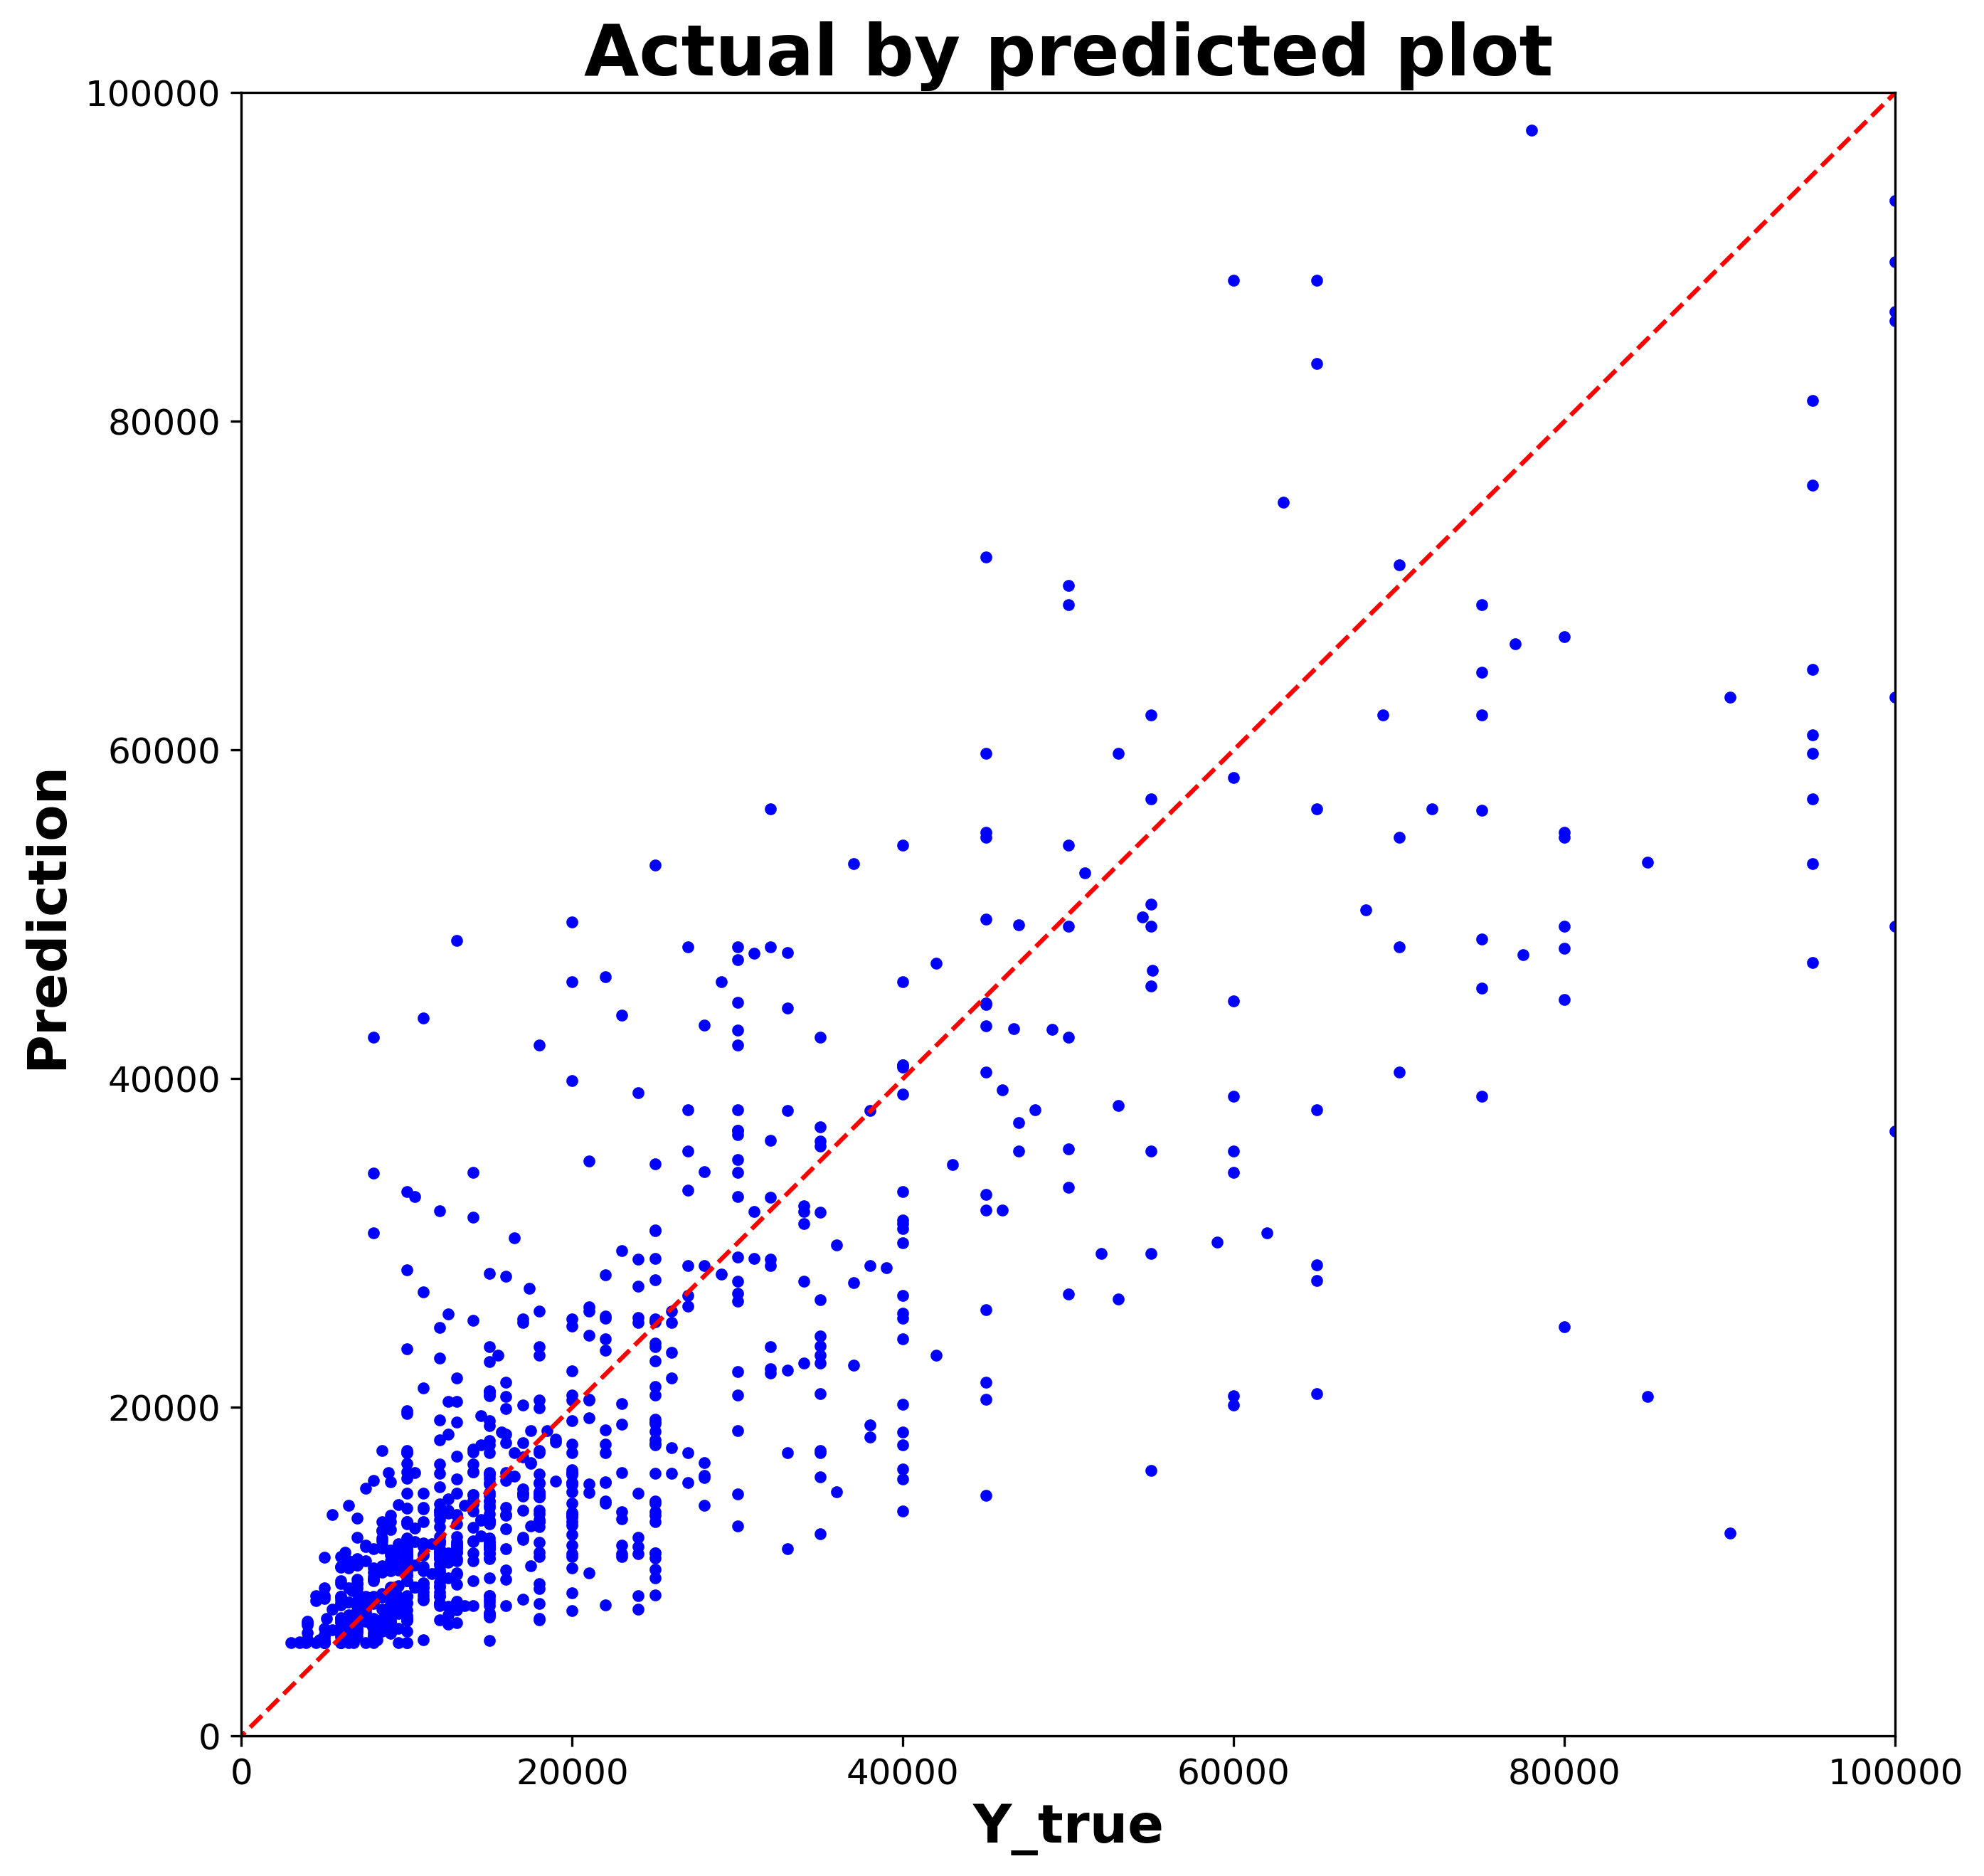

In [153]:
max_value=max(y_test)+100000
min_value=min(y_test)-100000

plt.figure(figsize=(10,10),dpi=300)
plt.title('Actual by predicted plot',weight='bold',fontsize=24)
plt.xlabel('Y_true',fontsize=18,weight='bold')
plt.ylabel('Prediction',fontsize=18,weight='bold')
plt.plot([min_value,max_value], [min_value,max_value], linestyle='--',color='red')
plt.scatter(Results.iloc[:,1],Results.iloc[:,2],marker='.',color='blue')

#plt.legend(loc=1,fontsize=18)
plt.ylim(0,100000)
plt.xlim(0,100000)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()